In [1]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import csv

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
#Keras
#import tensorflow as tf
import keras
#from keras.callbacks import ModelCheckpoint
#import eli5
#from eli5.sklearn import PermutationImportance
from keras import models
from keras import layers
from keras.models import Sequential       
from keras.layers.core import Dense
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [25]:
header = " "
for i in range(1, 41):
    header += f' .mfcc{i}'
header += ' label'
header = header.split()

In [26]:
file = open('data_mfcc_scratch.csv', 'w', newline='')
label1='covid'
label2='healthy'
hop_size = 10 #ms
FFT_size = 2048


with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = range(1,141)
map(str,genres)
for m in genres:
    
    if (m==29 or m==124):
            continue
            
    for filename in os.listdir(f'{m}'):
        songname = f'{m}/{filename}'
        audio, sample_rate = librosa.load(songname)

        #normalizes the audio signal
        def normalize_audio(audio):
            audio = audio / np.max(np.abs(audio))  
            #abs(audio) gives the amplitude of the audio samples
            #max(abs(audio)) gives the highest magnitude 
            return audio
        audio = normalize_audio(audio)
        
        #to define frame size
        def frame_audio(audio, FFT_size=1000, hop_size=200, sample_rate=sample_rate):
            # hop_size in ms
            audio = np.pad(audio, int(FFT_size / 2), mode='reflect')
            #frame_len= time of hop_size
            frame_len = np.round(sample_rate * hop_size / 1000).astype(int)
            #frame_num=[(sample_num-frame_size)/hop_size]+1
            frame_num = int((len(audio) - FFT_size) / frame_len) + 1
            #in frames, the FFT_size=window size or frame size
            frames = np.zeros((frame_num,FFT_size))
    
            for n in range(frame_num):
                frames[n] = audio[n*frame_len:n*frame_len+FFT_size]
                #takes each frame's duration (in ms) from (a to a+b) 
            return frames
        
        audio_framed = frame_audio(audio, FFT_size=FFT_size, hop_size=hop_size, sample_rate=sample_rate)
        #define a hanning window
        window = get_window("hann", FFT_size, fftbins=True)
        #apply haning window on all frames of audio signal
        audio_win = audio_framed * window
        
        audio_winT = np.transpose(audio_win)
        
        #compute fft
        audio_fft = np.empty((int(1 + FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')
        
        for n in range(audio_fft.shape[1]):
            audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]

        audio_fft = np.transpose(audio_fft)
        
        #calculate the amplitude of the power spectrum obtained
        audio_power = np.square(np.abs(audio_fft))
        
        #obtain minimum and maximum range of the audio signal to get mel filter banks
        freq_min = 0
        freq_high = sample_rate / 2
        #specify the number of filters required per frame
        mel_filter_num = 10
        
        #to convert from frequency to mel scale
        def freq_to_mel(freq):
            return 2595.0 * np.log10(1.0 + freq / 700.0)
        
        #to convert from mel to frequency scale
        def met_to_freq(mels):
            return 700.0 * (10.0**(mels / 2595.0) - 1.0)
        
        #to obtain filter points
        def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=sample_rate):
            fmin_mel = freq_to_mel(fmin)
            fmax_mel = freq_to_mel(fmax)
            #to divide the range of fmin and fmax (in mel) uniformly
            mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
            #convert the obtained mel frequencies to Hz
            freqs = met_to_freq(mels)
            return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs
    
        #find filter points and their associated mel frequencies
        filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, FFT_size, sample_rate=sample_rate)
        
        #finding weight of the filter points
        def get_filters(filter_points, FFT_size):
            filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))   
            
            #find the difference beween two filters. Normalize them between 0 and 1
            for n in range(len(filter_points)-2):
                filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
                filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
            return filters
        
        #calculate the filters so as to get a sawtooth waveform
        filters = get_filters(filter_points, FFT_size)
        
        #normalize the graph obtined on the  axis
        enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
        filters *= enorm[:, np.newaxis]
        
        #apply filter on the power spectrum of each frame
        audio_filtered = np.dot(filters, np.transpose(audio_power))
        
        #change the amplitude to log value
        audio_log = 10.0 * np.log10(audio_filtered+1e-10)
        
        #define a discrete cosine transform to obtain the cepstrum. However, we are using this transform to obtain both low and high frequencies of the audio signal
        def dct(dct_filter_num, filter_len):
            basis = np.empty((dct_filter_num,filter_len))
            basis[0, :] = 1.0 / np.sqrt(filter_len)
            samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)
            for i in range(1, dct_filter_num):
                basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
            return basis
        
        #specify the filter number for the discrete cosine transform
        dct_filter_num = 40
        
        #obtain dct filters
        dct_filters = dct(dct_filter_num, mel_filter_num)
        
        #apply dct on the log of the power spectrum to obtain the mfcc
        mfcc = np.dot(dct_filters, audio_log)
        mfcc=mfcc.T
        no_of_rows=len(mfcc)
        no_of_columns=mfcc.shape[1]
        for i in range (0,no_of_rows):
            mfcc_rows=" "
            mfcc_row=" "
            for j in range (0, no_of_columns):
                mfcc_row=mfcc[i,j].item()
                mfcc_rows+=f' {mfcc_row}'
            if (m<71):
                mfcc_rows+=f' {label1}'
            else:
                mfcc_rows+=f' {label2}'
            file = open('data_mfcc_scratch.csv', 'a', newline='')
            with file:
                writer = csv.writer(file)
                writer.writerow(mfcc_rows.split())
       

In [27]:
data = pd.read_csv('data_mfcc_scratch.csv')
data.head()

,.mfcc1,.mfcc2,.mfcc3,.mfcc4,.mfcc5,.mfcc6,.mfcc7,.mfcc8,.mfcc9,.mfcc10,...,.mfcc32,.mfcc33,.mfcc34,.mfcc35,.mfcc36,.mfcc37,.mfcc38,.mfcc39,.mfcc40,label
0,-316.227766,-4.263256e-14,5.684342e-14,-1.421085e-14,0.000000,-3.907985e-14,4.618528e-14,-1.421085e-14,-6.750156e-14,-1.421085e-13,...,5.382361e-13,2.220446e-13,2.202682e-13,-1.563194e-13,3.268497e-13,-2.842171e-14,-3.126388e-13,-6.181722e-13,1.023182e-12,covid
1,-316.227766,-4.263256e-14,5.684342e-14,-1.421085e-14,0.000000,-3.907985e-14,4.618528e-14,-1.421085e-14,-6.750156e-14,-1.421085e-13,...,5.382361e-13,2.220446e-13,2.202682e-13,-1.563194e-13,3.268497e-13,-2.842171e-14,-3.126388e-13,-6.181722e-13,1.023182e-12,covid
2,-316.227766,-4.263256e-14,5.684342e-14,-1.421085e-14,0.000000,-3.907985e-14,4.618528e-14,-1.421085e-14,-6.750156e-14,-1.421085e-13,...,5.382361e-13,2.220446e-13,2.202682e-13,-1.563194e-13,3.268497e-13,-2.842171e-14,-3.126388e-13,-6.181722e-13,1.023182e-12,covid
3,-316.227766,-4.263256e-14,5.684342e-14,-1.421085e-14,0.000000,-3.907985e-14,4.618528e-14,-1.421085e-14,-6.750156e-14,-1.421085e-13,...,5.382361e-13,2.220446e-13,2.202682e-13,-1.563194e-13,3.268497e-13,-2.842171e-14,-3.126388e-13,-6.181722e-13,1.023182e-12,covid
4,-316.080397,1.246122e-01,2.040798e-02,1.738474e-03,0.010304,-4.078118e-03,-1.482828e-02,-2.315213e-02,-3.039130e-02,-2.141452e-02,...,-2.141452e-02,-3.039130e-02,-2.315213e-02,-1.482828e-02,-4.078118e-03,1.030437e-02,1.738474e-03,2.040798e-02,1.246122e-01,covid


In [28]:
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

In [29]:
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [31]:
#we use this split for ANN
X_testmod,X_val,y_testmod,y_val=train_test_split(X_test,y_test,test_size=0.5,random_state=0)


#initialise the ANN, defines ANN as sequence of layers
model = models.Sequential()
#we will add the input layer and the 1st hidden layer
#here the .add adds different layers
#the first parameter specifies the number of nodes in the hidden layer. It is generally calculated as the average(number of input layers+number of output layers) 
#the rectifier function is used as the activation function for the hidden layer 
model.add(layers.Dense(14, activation='relu', input_shape=(X_train.shape[1],)))
#we will add another hidden layer 
#model.add(layers.Dense(14, activation='relu'))
#add the output layer
#output_dim=outcome for the output layer. Here it is set to 1 because the outcome is binary, i.e., covid or healthy
#the activation function used on the output layer is sigmoid. This is to get the probability of the outcome
model.add(layers.Dense(1, activation='sigmoid'))

In [32]:
#compile the ANN
#we will use Stochastic Gradient Descent to the entire ANN to find the optimal set of weights. There are many types of descent. we have used 'adam' algorithm as our stochastic gradient descent. 
#this 'adam' algorithm is based on loss function. For example, in simple linear regression the loss function is the sum of the difference between the real value and predicted value. For stochastic gradient descent, the the loss function is the logarithmic loss  
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [33]:
#Fit ANN to the training set
#NOTE: there is no standard rule to select batch_size or epochs. Generally the batch_size=10 and epochs=100
history = model.fit(X_train,
                    y_train,
                    epochs=40,
                    batch_size=20, validation_data=(X_val,y_val) )

Train on 56595 samples, validate on 7075 samples
Epoch 1/40
56595/56595 [==============================] - 4s 67us/step - loss: 0.6603 - accuracy: 0.6071 - val_loss: 0.6513 - val_accuracy: 0.6211
Epoch 2/40
56595/56595 [==============================] - 3s 61us/step - loss: 0.6419 - accuracy: 0.6324 - val_loss: 0.6410 - val_accuracy: 0.6322
Epoch 3/40
56595/56595 [==============================] - 3s 61us/step - loss: 0.6344 - accuracy: 0.6383 - val_loss: 0.6357 - val_accuracy: 0.6356
Epoch 4/40
56595/56595 [==============================] - 3s 61us/step - loss: 0.6301 - accuracy: 0.6431 - val_loss: 0.6297 - val_accuracy: 0.6406
Epoch 5/40
56595/56595 [==============================] - 3s 61us/step - loss: 0.6260 - accuracy: 0.6462 - val_loss: 0.6354 - val_accuracy: 0.6387
Epoch 6/40
56595/56595 [==============================] - 3s 61us/step - loss: 0.6234 - accuracy: 0.6494 - val_loss: 0.6262 - val_accuracy: 0.6442
Epoch 7/40
56595/56595 [==============================] - 3s 62us/ste

In [34]:
test_loss, test_acc = model.evaluate(X_testmod,y_testmod)
print('test_acc:, test_loss',test_acc, test_loss)

7074/7074 [==============================] - 0s 17us/step
test_acc:, test_loss 0.6463104486465454 0.6283898681848777


In [35]:
#predict the test set result
#predictions shows the probability of the outcome being covid or healthy
predictions = model.predict(X_testmod)
#it means that if predictions >0.5, the subject is healthy. Else he is a covid patient
#we get the predictions output as true and false
predictions=(predictions>0.5)
#the predictions values are converted to 0 and 1
predictions = np.multiply(predictions, 1)
#implement the confusion matrix
cm=confusion_matrix(y_testmod,predictions)
auc = roc_auc_score(y_testmod, predictions)

In [36]:
print("\n area under the curve=",auc)
print("\n confusion matrix is\n", cm)


 area under the curve= 0.6456219427287179

 confusion matrix is
 [[2438 1194]
 [1308 2134]]


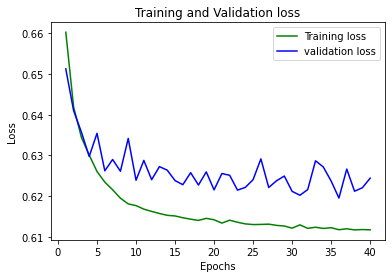

In [37]:
#Visualizing train and validation loss
loss_train = history.history['loss']
loss_val = history.history['val_loss']
loss_train=np.array(loss_train)
loss_val=np.array(loss_val)
epochs = range(1,41)
epochs=np.array(epochs)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

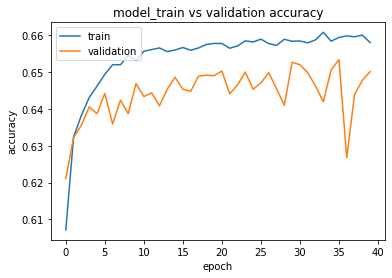

In [38]:
#Visualizing train and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
epoch=range(1,41)
plt.title('model_train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc='upper left')
plt.show()

In [39]:
#try SVM with scikit learn
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train)
y_pred=classifier.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
acc=accuracy_score(y_pred,y_test)
auc = roc_auc_score(y_test, y_pred)

TP = cm[0][0]
FN = cm[0][1]
FP = cm[1][0]
TN = cm[1][1]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP)

#applying 5 cross validation
accuracies=cross_val_score(estimator=classifier,X=X_train, y=y_train, cv=5)
c=accuracies.mean()
d=accuracies.std()

In [8]:
print("mean of accuracies=",c,"\n mean of variance=",d,"\n accuracy=",acc,"\n sensitivity=",TPR,"\n specificity=",TNR,"\n area under the curve=",auc)
print("\n confusion matrix is\n", cm)

mean of accuracies= 0.7527343404894424 
 mean of variance= 0.005021780555719662 
 sensitivity= 0.8017264634475317 
 specificity= 0.7051224944320713 
 area under the curve= 0.7534244789398016

 confusion matrix is
 [[5944 1470]
 [1986 4749]]


In [21]:
#try logistic regression with scikit learn
from sklearn.linear_model import LogisticRegression
classifier=LogisticRegression()
classifier.fit(X_train, y_train)
y_pred=classifier.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
acc=accuracy_score(y_pred,y_test)
auc = roc_auc_score(y_test, y_pred)

TP = cm[0][0]
FN = cm[0][1]
FP = cm[1][0]
TN = cm[1][1]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP)

#applying 5 cross validation
accuracies=cross_val_score(estimator=classifier,X=X_train, y=y_train, cv=5)
c=accuracies.mean()
d=accuracies.std()

In [22]:
print("mean of accuracies=",c,"\n mean of variance=",d,"\n accuracy=",acc,"\n sensitivity=",TPR,"\n specificity=",TNR,"\n area under the curve=",auc)
print("\n confusion matrix is\n", cm)

mean of accuracies= 0.5730718261330506 
 mean of variance= 0.0020042122361974557 
 accuracy= 0.5750229698211887 
 sensitivity= 0.6857297005664958 
 specificity= 0.4531551596139569 
 area under the curve= 0.5694424300902263

 confusion matrix is
 [[5084 2330]
 [3683 3052]]


In [19]:
#try naive bayes with scikit learn
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)
y_pred=classifier.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
acc=accuracy_score(y_pred,y_test)
auc = roc_auc_score(y_test, y_pred)

TP = cm[0][0]
FN = cm[0][1]
FP = cm[1][0]
TN = cm[1][1]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP)

#applying 5 cross validation
accuracies=cross_val_score(estimator=classifier,X=X_train, y=y_train, cv=5)
c=accuracies.mean()
d=accuracies.std()


In [20]:
print("mean of accuracies=",c,"\n mean of variance=",d,"\n accuracy=",acc,"\n sensitivity=",TPR,"\n specificity=",TNR,"\n area under the curve=",auc)
print("\n confusion matrix is\n", cm)

mean of accuracies= 0.5793089902759732 
 mean of variance= 0.006205613450492715 
 accuracy= 0.5736094423634179 
 sensitivity= 0.5600215807930942 
 specificity= 0.5885671863400148 
 area under the curve= 0.5742943835665545

 confusion matrix is
 [[4152 3262]
 [2771 3964]]
